<h1>Costa Rica's Household Poverty Prediction</h1>

Many social programs have a hard time making sure the right people are given enough aid.<br>
It’s especially tricky when a program focuses on the poorest segment of the population.<br>
The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.<br><br>
In Latin America, one popular method uses an algorithm to verify income qualification, It’s called the <b>Proxy Means Test (or PMT)</b>.<br>
With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.<br><br>
While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.<br>
there is a belief that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.<br><br>
The data contains 142 columns, with core columns:
- Id - a unique identifier for each row.
- Target - the target is an ordinal variable indicating groups of income levels.
        1 = extreme poverty
        2 = moderate poverty
        3 = vulnerable households
        4 = non vulnerable households
- idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
- parentesco1 - indicates if this person is the head of the household.

Full data available here 
https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

The workflow in this project:
- import the data
- clean the data
- find relevant parameters 
- create a model
- optimize the model 
- fit and test the model

<h4>Importing libraries</h4>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate
from bayes_opt import BayesianOptimization # use !pip install bayesian-optimization
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

<h4>Importing data</h4>

In [ ]:
train=r'train.csv'

In [4]:
train_df=pd.read_csv(train)
train_df

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,NaN,0,...,81,2116,25,81,1,1.562500,0.0625,68.0625,2116,2
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,NaN,0,...,0,4,25,81,1,1.562500,0.0625,68.0625,4,2
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,NaN,0,...,25,2500,25,81,1,1.562500,0.0625,68.0625,2500,2
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,NaN,0,...,121,676,25,81,1,1.562500,0.0625,68.0625,676,2


<h3>CLEANING PROCESS</h3>

In [6]:
def clean_df(train_df):
    print(train_df.columns[train_df.isnull().sum() > 0]) #print columns with null values
    train_df.fillna(method='bfill', inplace=True) #fill null values with the next valid observation
    print(train_df.columns[train_df.isnull().sum() > 0])
    train_df.fillna(method='ffill', inplace=True) #fill null values with the last valid observation
    print(train_df.columns[train_df.isnull().sum() > 0])
    result=train_df
    return result
train_df=clean_df(train_df)
train_df

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,1.0,0,...,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,ID_68de51c94,180000.0,0,8,0,1,1,0,1.0,0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,ID_d45ae367d,80000.0,0,6,0,1,1,0,1.0,0,...,81,2116,25,81,1,1.562500,0.0625,68.0625,2116,2
9553,ID_c94744e07,80000.0,0,6,0,1,1,0,1.0,0,...,0,4,25,81,1,1.562500,0.0625,68.0625,4,2
9554,ID_85fc658f8,80000.0,0,6,0,1,1,0,1.0,0,...,25,2500,25,81,1,1.562500,0.0625,68.0625,2500,2
9555,ID_ced540c61,80000.0,0,6,0,1,1,0,1.0,0,...,121,676,25,81,1,1.562500,0.0625,68.0625,676,2


In [7]:
# finding numeric and categorical columns
numeric_columns=train_df.select_dtypes(include=np.number).columns.tolist()
not_numeric_col=set(train_df.columns).difference(set(numeric_columns))

print(not_numeric_col) #those columns contain strings and numbers, or only strings

{'Id', 'dependency', 'edjefa', 'idhogar', 'edjefe'}


<b><u>The categorical columns found-</b></u><br>
<u>edjefa-</u> years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0- <b>will change yes cell to 1 and no cells to 0</b><br>
<u>edjefe-</u> years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0- <b>will change yes cell to 1 and no cells to 0</b><br>
<u>dependency-</u> Dependency rate, calculated = (number of household members younger than 19 or older than 64)/(number of household members between 19 and 64)- <b>will drop this colum- we have a squared values column of dependency called SQBdependency all numeric values</b><br>
<u>Id-</u> a unique identifier for each row- <b>will drop this colum- we don't need this column in the model</b><br>
<u>idhogar-</u> this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier- <b>will drop this colum- we don't need this column in the model</b>

In [8]:
def editing_columns(train_df):
    train_df['edjefe'] = train_df['edjefe'].replace({'no': 0, 'yes':1}).astype(float)
    train_df['edjefa'] = train_df['edjefa'].replace({'no': 0, 'yes':1}).astype(float)
    train_df=train_df.drop(['dependency', 'Id', 'idhogar'], axis=1)
    return train_df
train_df= editing_columns(train_df)
train_df

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,190000.0,0,3,0,1,1,0,1.0,0,1,...,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,180000.0,0,8,0,1,1,0,1.0,0,0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,80000.0,0,6,0,1,1,0,1.0,0,2,...,81,2116,25,81,1,1.562500,0.0625,68.0625,2116,2
9553,80000.0,0,6,0,1,1,0,1.0,0,2,...,0,4,25,81,1,1.562500,0.0625,68.0625,4,2
9554,80000.0,0,6,0,1,1,0,1.0,0,2,...,25,2500,25,81,1,1.562500,0.0625,68.0625,2500,2
9555,80000.0,0,6,0,1,1,0,1.0,0,2,...,121,676,25,81,1,1.562500,0.0625,68.0625,676,2


In [9]:
#check if there are still columns with strings
numeric_columns=train_df.select_dtypes(include=np.number).columns.tolist()
not_numeric_col=set(train_df.columns).difference(set(numeric_columns))

print(not_numeric_col) #those columns contain strings and numbers, or only strings

set()


<h3>FEATURE ENGINEERING</h3>

In order to improve the model's accuracy, we'll preform some feature engineering steps

In [10]:
corr_df=train_df.corr()
corr_df.style.apply(lambda table: ["background: red" if val > 0.5 or val < -0.5 else "" for val in table])

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
v2a1,1.000000,-0.075851,0.243106,-0.063946,-0.006030,0.082179,0.218425,0.176238,-0.066541,-0.015703,-0.051795,-0.043414,0.035669,0.002669,-0.071940,0.011800,-0.032948,-0.039399,-0.037651,0.195776,0.016415,-0.039399,0.187433,-0.091370,-0.092538,0.000056,-0.087394,-0.034979,-0.010594,0.023515,0.196842,-0.175835,0.011826,0.000729,-0.052519,-0.045712,-0.018714,0.018352,-0.002571,0.002071,0.246407,0.081187,-0.071486,-0.041133,0.131844,-0.012354,-0.025244,-0.126568,-0.011822,0.155832,-0.127065,-0.070718,-0.010740,0.002845,0.213430,-0.179400,-0.079864,0.217353,-0.100647,-0.183364,-0.028791,nan,-0.018276,-0.102772,-0.134972,0.190890,-0.083207,-0.089135,0.138346,-0.132847,-0.095296,0.170361,-0.013086,-0.016180,0.016180,-0.029766,-0.072097,0.063310,0.026142,-0.016166,0.017462,0.004438,0.010712,0.007114,-0.016915,-0.041886,0.000262,-0.001797,0.013001,0.008220,0.004534,0.009490,0.023110,0.001359,-0.093352,0.049492,0.048375,-0.039399,0.170237,0.069829,0.270541,-0.047143,-0.078179,-0.071775,-0.027676,0.034543,-0.014530,0.003910,0.178447,0.113749,0.159995,-0.148341,-0.036271,0.158131,-0.020503,-0.037899,-0.062333,0.166543,0.088306,0.018401,0.081392,0.328662,-0.041141,-0.055841,-0.125251,-0.178456,-0.182860,0.277684,-0.277684,0.062352,0.227601,0.058830,-0.041588,0.229527,-0.081964,-0.128309,0.024876,0.256650,0.058830,0.165706
hacdor,-0.075851,1.000000,-0.233369,0.652594,-0.175011,-0.101965,-0.084680,-0.059757,0.232508,0.059313,0.184857,0.268978,0.142458,0.264620,0.328901,0.134909,0.304282,0.304884,0.350948,-0.122134,0.041632,0.304884,-0.136055,0.074927,-0.027202,0.147449,0.083620,0.155120,-0.007622,-0.007622,-0.168472,0.077334,-0.006109,0.078103,0.232319,0.055087,-0.042053,-0.026698,-0.011166,-0.009338,-0.177257,-0.053838,0.060714,-0.011890,0.018548,-0.003526,-0.009338,-0.016256,0.102032,-0.018513,0.011347,-0.024871,-0.009984,-0.008644,-0.074592,0.052816,0.052003,-0.039592,-0.002982,0.049567,-0.007622,nan,-0.007055,0.186977,0.053383,-0.165127,0.150780,0.046047,-0.144617,0.248834,0.035195,-0.188850,-0.013962,-0.010899,0.010899,0.101245,0.048446,-0.083512,-0.036129,-0.004175,-0.024646,-0.004303,-0.059319,-0.035260,0.014650,0.052828,0.019894,0.095210,-0.003598,-0.009773,-0.003996,-0.001394,0.031250,0.034400,0.316924,0.092055,-0.047062,0.304884,-0.085261,-0.014988,-0.108822,0.084845,0.043483,0.001882,-0.003503,-0.043254,-0.018611,-0.007391,-0.070758,-0.024871,-0.209735,0.670727,-0.063173,-0.066533,0.073560,0.151115,0.010075,-0.067109,-0.075837,-0.059923,0.004046,-0.042086,0.017444,0.025546,-0.010172,0.037182,0.005289,0.027721,-0.027721,-0.118168,-0.109862,-0.102725,0.350546,-0.082229,0.388043,0.794699,0.005278,-0.09917

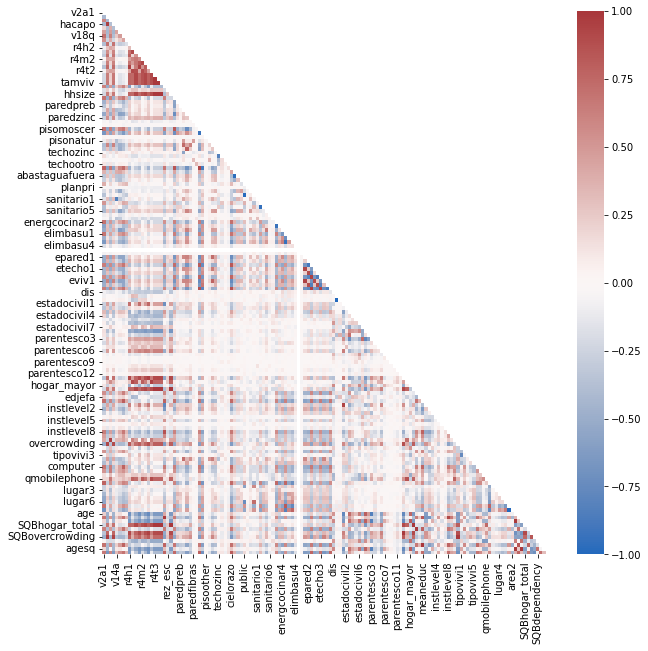

In [11]:
fig,axs=plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(corr_df.corr(method='pearson'), dtype=bool))
sns.heatmap(corr_df.corr(method='pearson'), vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [24]:
def creating_final_df(train_df):
    train_df_final=pd.DataFrame()
    train_df_final['parentesco1']=train_df['parentesco1']
    if 'Target' in train_df.columns:
        train_df_final['Target']=train_df['Target']
    

    train_df_final['rent_per_adult'] = train_df['v2a1']/train_df['hogar_adul'] # monthly rent/number of adults in the household
    train_df_final['rent_per_person'] = train_df['v2a1']/train_df['hhsize'] # monthly rent/household size

    train_df_final['overcrowding_room_and_bedroom'] = (train_df['hacdor'] + train_df['hacapo'])/2 #(Overcrowding by bedrooms+Overcrowding by rooms)/2

    train_df_final['no_appliances'] = train_df['refrig'] + train_df['computer'] + train_df['television'] #if the household has refrigerator+if the household has computer+if the household has TV

    train_df_final['r4h1_percent_in_male'] = train_df['r4h1'] / train_df['r4h3'] #all males younger than 12/total males in household
    train_df_final['r4m1_percent_in_female'] = train_df['r4m1'] / train_df['r4m3'] #all females younger than 12/total males in household
    train_df_final['r4h1_percent_in_total'] = train_df['r4h1'] / train_df['hhsize'] #all males younger than 12/household size
    train_df_final['r4m1_percent_in_total'] = train_df['r4m1'] / train_df['hhsize'] #all females younger than 12/household size
    train_df_final['r4t1_percent_in_total'] = train_df['r4t1'] / train_df['hhsize'] #all people younger than 12/household size

    train_df_final['adult'] = train_df['hogar_adul'] - train_df['hogar_mayor'] # adults in household/people 65+ in household
    train_df_final['dependency_count'] = train_df['hogar_nin'] + train_df['hogar_mayor'] # people 0-19 in household/people 65+ in household
    train_df_final['dependency'] = train_df_final['dependency_count'] / train_df_final['adult']
    train_df_final['child_percent'] = train_df['hogar_nin']/train_df['hogar_total'] # people 0-19 in household/total people in household
    train_df_final['elder_percent'] = train_df['hogar_mayor']/train_df['hogar_total'] # people 65+ in household/total people in household
    train_df_final['adult_percent'] = train_df['hogar_adul']/train_df['hogar_total'] # adults in household/total people in household

    train_df_final['rent_per_bedroom'] = train_df['v2a1']/train_df['bedrooms'] # monthly rent/bedrooms
    train_df_final['adults_per_bedroom'] = train_df_final['adult']/train_df['bedrooms']
    train_df_final['child_per_bedroom'] = train_df['hogar_nin']/train_df['bedrooms']
    train_df_final['male_per_bedroom'] = train_df['r4h3']/train_df['bedrooms']

    train_df_final['female_per_bedroom'] = train_df['r4m3']/train_df['bedrooms'] # total female in household/bedrooms
    train_df_final['bedrooms_per_person_household'] = train_df['hhsize']/train_df['bedrooms'] # household size/bedrooms

    train_df_final['tablet_per_person_household'] = train_df['v18q1']/train_df['hhsize'] # number of tablets household owns/household size
    train_df_final['phone_per_person_household'] = train_df['qmobilephone']/train_df['hhsize'] # number of mobile phones household owns/household size

    train_df_final['age_12_19'] = train_df['hogar_nin'] - train_df['r4t1'] # people 0-19 in household/people under 12 in household

    train_df_final['rent_per_room'] = train_df['v2a1']/train_df['rooms'] # monthly rent/rooms
    train_df_final['bedroom_per_room'] = train_df['bedrooms']/train_df['rooms']
    train_df_final['elder_per_room'] = train_df['hogar_mayor']/train_df['rooms'] #people 65+ in household/rooms
    train_df_final['adults_per_room'] = train_df_final['adult']/train_df['rooms']
    train_df_final['child_per_room'] = train_df['hogar_nin']/train_df['rooms'] # people 0-19 in household/rooms
    train_df_final['male_per_room'] = train_df['r4h3']/train_df['rooms'] # all males in household/rooms
    train_df_final['female_per_room'] = train_df['r4m3']/train_df['rooms'] # all females in household/rooms
    train_df_final['room_per_person_household'] = train_df['hhsize']/train_df['rooms'] # household size/rooms
    train_df_final['escolari_age'] = train_df['escolari']/train_df['age'] # schooling years/age

    train_df_final['rez_esc_escolari'] = train_df['rez_esc']/train_df['escolari'] # years behind in school/schooling years
    train_df_final['rez_esc_r4t1'] = train_df['rez_esc']/train_df['r4t1'] # years behind in school/all people younger than 12 in householde
    train_df_final['rez_esc_r4t2'] = train_df['rez_esc']/train_df['r4t2'] # years behind in school/all people older than 12 in householde
    train_df_final['rez_esc_r4t3'] = train_df['rez_esc']/train_df['r4t3'] # years behind in school/total people in householde
    train_df_final['rez_esc_age'] = train_df['rez_esc']/train_df['age'] # years behind in school/age
    
    return train_df_final

train_df_final=creating_final_df(train_df)
train_df_final

,parentesco1,Target,rent_per_adult,rent_per_person,overcrowding_room_and_bedroom,no_appliances,r4h1_percent_in_male,r4m1_percent_in_female,r4h1_percent_in_total,r4m1_percent_in_total,...,child_per_room,male_per_room,female_per_room,room_per_person_household,escolari_age,rez_esc_escolari,rez_esc_r4t1,rez_esc_r4t2,rez_esc_r4t3,rez_esc_age
0,1,4,190000.0,190000.0,0.0,1,0.0,NaN,0.0,0.00,...,0.000000,0.333333,0.000,0.333333,0.232558,0.100000,inf,1.000000,1.00,0.023256
1,1,4,135000.0,135000.0,0.0,1,0.0,NaN,0.0,0.00,...,0.000000,0.250000,0.000,0.250000,0.179104,0.083333,inf,1.000000,1.00,0.014925
2,1,4,180000.0,180000.0,0.0,1,NaN,0.000000,0.0,0.00,...,0.000000,0.000000,0.125,0.125000,0.119565,0.090909,inf,1.000000,1.00,0.010870
3,0,4,90000.0,45000.0,0.0,1,0.0,0.500000,0.0,0.25,...,0.400000,0.400000,0.400,0.800000,0.529412,0.111111,1.0,0.333333,0.25,0.058824
4,0,4,90000.0,45000.0,0.0,1,0.0,0.500000,0.0,0.25,...,0.400000,0.400000,0.400,0.800000,0.297297,0.000000,0.0,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,1,2,20000.0,16000.0,0.0,2,0.0,0.333333,0.0,0.20,...,0.166667,0.333333,0.500,0.833333,0.195652,0.000000,0.0,0.000000,0.00,0.000000
9553,0,2,20000.0,16000.0,0.0,2,0.0,0.333333,0.0,0.20,...,0.166667,0.333333,0.500,0.833333,0.000000,NaN,0.0,0.000000,0.00,0.000000
9554,0,2,20000.0,16000.0,0.0,2,0.0,0.333333,0.0,0.20,...,0.166667,0.333333,0.500,0.833333,0.100000,0.000000,0.0,0.000000,0.00,0.000000
9555,0,2,20000.0,16000.0,0.0,2,0.0,0.333333,0.0,0.20,...,0.166667,0.333333,0.500,0.833333,0.423077,0.000000,0.0,0.000000,0.00,0.000000


In [13]:
corr_df=train_df_final.corr()
corr_df.style.apply(lambda table: ["background: red" if val > 0.5 or val < -0.5 else "" for val in table])

,parentesco1,Target,rent_per_adult,rent_per_person,overcrowding_room_and_bedroom,no_appliances,r4h1_percent_in_male,r4m1_percent_in_female,r4h1_percent_in_total,r4m1_percent_in_total,r4t1_percent_in_total,adult,dependency_count,dependency,child_percent,elder_percent,adult_percent,rent_per_bedroom,adults_per_bedroom,child_per_bedroom,male_per_bedroom,female_per_bedroom,bedrooms_per_person_household,tablet_per_person_household,phone_per_person_household,age_12_19,rent_per_room,bedroom_per_room,elder_per_room,adults_per_room,child_per_room,male_per_room,female_per_room,room_per_person_household,escolari_age,rez_esc_escolari,rez_esc_r4t1,rez_esc_r4t2,rez_esc_r4t3,rez_esc_age
parentesco1,1.000000,0.037903,0.116259,0.185012,-0.061136,-0.033953,-0.078702,-0.091958,-0.092476,-0.094460,-0.132419,-0.215957,-0.204541,-0.112393,-0.188089,0.135478,0.188089,0.066406,-0.135262,-0.179766,-0.150418,-0.147589,-0.195906,0.266823,0.111176,-0.147287,0.044484,-0.071258,0.056579,-0.144212,-0.174207,-0.153470,-0.156847,-0.195264,-0.235087,0.008666,-0.004604,0.066829,0.082469,-0.096162
Target,0.037903,1.000000,0.074516,0.161306,-0.184503,0.243289,-0.248590,-0.208871,-0.192729,-0.215471,-0.289337,0.159667,-0.339183,-0.376901,-0.320388,0.004136,0.320388,0.100950,0.032747,-0.374951,-0.151780,-0.274250,-0.281959,0.096897,0.298884,-0.136906,0.092522,-0.049988,-0.048825,0.017443,-0.370620,-0.150907,-0.273809,-0.267415,0.147849,-0.093512,0.009698,-0.031943,0.001124,-0.059819
rent_per_adult,0.116259,0.074516,1.000000,0.874483,-0.081632,0.075653,0.038014,0.022434,-0.004855,0.025262,0.014753,-0.294382,-0.075916,0.082200,0.040851,0.065767,-0.040851,0.774013,-0.264848,-0.063581,-0.212991,-0.110233,-0.213029,0.308107,0.137984,-0.038528,0.764788,-0.127032,-0.032570,-0.281640,-0.083683,-0.232145,-0.138039,-0.234329,0.057034,-0.023742,-0.022163,0.110433,0.111704,-0.006519
rent_per_person,0.185012,0.161306,0.874483,1.000000,-0.104577,0.086560,-0.139461,-0.138940,-0.144574,-0.133342,-0.196726,-0.249469,-0.271160,-0.178384,-0.279347,0.208620,0.279347,0.753302,-0.225580,-0.281622,-0.257039,-0.225866,-0.319874,0.420725,0.235554,-0.204886,0.725987,-0.142526,0.075018,-0.249725,-0.277624,-0.270484,-0.244787,-0.326810,0.024339,-0.022243,0.001966,0.136000,0.169806,-0.035449
overcrowding_room_and_bedroom,-0.061136,-0.184503,-0.081632,-0.104577,1.000000,-0.128275,0.171043,0.165326,0.131366,0.153412,0.201915,0.140274,0.321586,0.180232,0.172427,-0.064357,-0.172427,0.001172,0.403146,0.503941,0.461033,0.486600,0.621697,-0.136019,-0.151166,0.094485,0.036168,0.135363,-0.007337,0.476390,0.556571,0.527354,0.552437,0.677524,-0.060917,0.067315,0.042049,0.020329,-0.007504,0.065816
no_appliances,-0.033953,0.243289,0.075653,0.086560,-0.128275,1.000000,-0.094562,-0.072781,-0.075925,-0.060004,-0.096116,0.140904,-0.097494,-0.142610,-0.099224,-0.010947,0.099224,0.063480,-0.053003,-0.177047,-0.140736,-0.130317,-0.177930,-0.017891,0.225382,-0.034350,0.065780,-0.031870,-0.030168,-0.053327,-0.171191,-0.133393,-0.123777,-0.161699,0.128646,-0.074025,-0.012214,-0.038710,-0.029803,-0.032326
r4h1_percent_in_male,-0.078702,-0.248590,0.038014,-0.139461,0.171043,-0.094562,1.000000,0.153271,0.922311,0.130746,0.754846,-0.087124,0.408386,0.382090,0.521148,-0.205929,-0.521148,-0.025054,-0.000738,0.491663,0.299491,0.209338,0.320902,-0.168431,-0.297482,-0.081896,-0.025962,0.017910,-0.176389,0.003115,0.461790,0.269771,0.204438,0.290078,-0.099240,-0.017663,-0.089100,0.006383,-0.078129,0.074596
r4m1_percent_in_female,-0.091958,-0.208871,0.022434,-0.138940,0.165326,-0.072781,0.153271,1.000000,0.052734,0.955621,0.728260,-0.045702,0.418643,0.368525,0.509314,-0.217804,-0.509314,-0.022981,0.008510,0.474475,0.001520,0.461769,0.308612,-0.184612,-0.285348,-0.056435,-0.008916,0.036558,-0.189057,0.020582,0.455482,0.020130,0.445558,0.292461,-0.102038,-0.008058,-0.090169,-0.004748,-0.085735,0.090627
r4h1_percent_in_total,-0.092476,-0.192729,-0.004855,-0.144574,0.131366,-0.075925,0.922311,0.052734,1.000000,-0.003452,0.695900,-0.

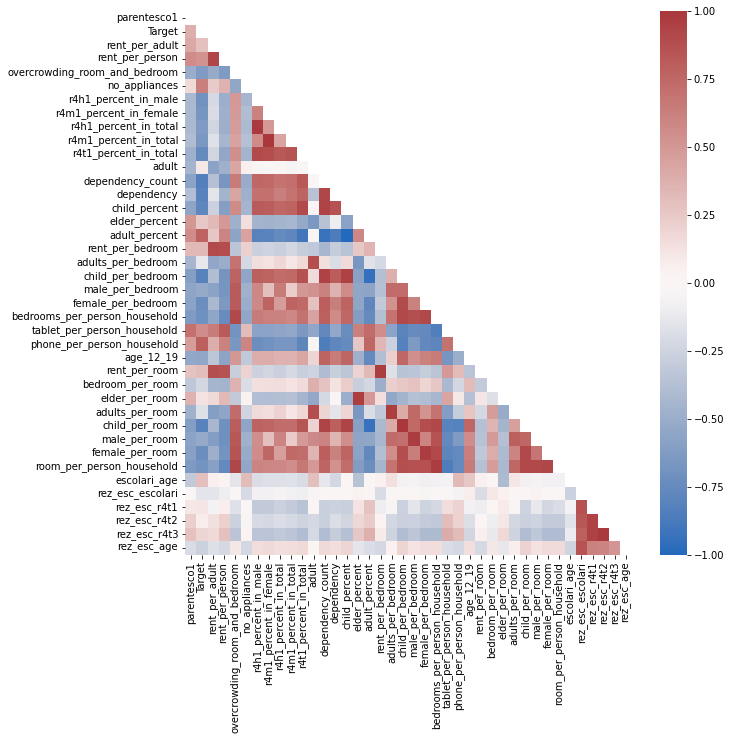

In [14]:
fig,axs=plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(corr_df.corr(method='pearson'), dtype=bool))
sns.heatmap(corr_df.corr(method='pearson'), vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

<h3>CREATING THE MODEL</h3>

dividing the train dataset to data (X_train) and target (y_train)

In [39]:
X_train=train_df_final.drop('Target',axis=1)
y_train=train_df_final['Target']

<h3>OPTIMIZERS</h3>

<h4>OPTIMIZING CATBOOST</h4><br>
<b>CatBoost</b> is a high-performance open source library for gradient boosting on decision trees.<br>
CatBoost is an algorithm for gradient boosting on decision trees.<br>
In each step, the same feature-split pair that results in the lowest loss is chosen and applied to all the nodes in that level.<br>
It is a readymade classifier in scikit-learn’s conventions terms that would deal with categorical features automatically.<br>
Also, it provides best-in-class accuracy.<br>
Advantages-<br>
1. <b>Performance-</b> CatBoost provides state of the art results and it is competitive with any leading machine learning algorithm on the performance front.<br>
2. <b>Handling Categorical features automatically-</b> We can use CatBoost without any explicit pre-processing to convert categories into numbers.<br>
CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.<br>
3. <b>Robust-</b> It reduces the need for extensive hyper-parameter tuning and lower the chances of overfitting also which leads to more generalized models.<br>
Although, CatBoost has multiple parameters to tune and it contains parameters like the number of trees, learning rate, regularization, tree depth, fold size, bagging temperature and others.<br>
4. <b>Easy-to-use-</b> We can use CatBoost from the command line, using an user-friendly API for both Python and R.

In [40]:
def cb_cv(n_estimators, depth, X, y):
    estimator = CatBoostClassifier(n_estimators=n_estimators, depth=depth, random_state = 2, verbose = 0)
    cval = cross_val_score(estimator, X, y,cv=5)
    return cval.mean()

def optimize_cb(X, y):
    def cb_crossval(n_estimators, depth):
        return cb_cv(n_estimators=int(n_estimators),
                     #learning_rate = learning_rate,
                     depth = int(depth),X=X,y=y,)

    optimizer = BayesianOptimization(f=cb_crossval,
                                     pbounds={"n_estimators": (200, 600),
                                              #"learning_rate": (0.01,10),
                                              "depth": (4,16),},
                                     random_state=1234,
                                     verbose=2)
    optimizer.maximize(n_iter=10, init_points=10)

    return optimizer.max['params'] 


In [ ]:
print("--- Optimizing Catboost ---")
cb_params=optimize_cb(X_train, y_train)
cb_params

--- Optimizing Catboost ---
|   iter    |  target   |   depth   | n_esti... |
-------------------------------------------------
| 1         | 0.6196    | 6.298     | 448.8     |
| 2         | 0.6205    | 9.253     | 514.1     |
| 3         | 0.6168    | 13.36     | 309.0     |
| 4         | 0.6181    | 7.318     | 520.7     |


<h4>OPTIMIZING LGBM</h4><br>
<b>LGBM/LightGBM (Light Gradient Boosting Machine)</b>- is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency
- Lower memory usage
- Better accuracy
- Support of parallel and GPU learning
- Capable of handling large-scale data

<b>XGBoost vs. LightGBM-</b><br>
XGBoost is a very fast and accurate ML algorithm, But now it's been challenged by LightGBM — which runs even faster with comparable model accuracy and more hyperparameters for users to tune.<br>
The key difference in speed is because XGBoost split the tree nodes one level at a time and LightGBM does that one node at a time.<br>
Another difference between XGBoost and LightGBM is that XGBoost has a feature that LightGBM lacks — monotonic constraint. It will sacrifice some model accuracy and increase training time, but may improve model interpretability.

In [ ]:
def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, X, y):
    """
    n_estimators- number of boosting iterations
    num_leaves- main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth).
    Value more than this will result in overfitting.
    min_child_samples- minimal number of data in one leaf. Can be used to deal with over-fitting
    """
    estimator = LGBMClassifier(n_estimators=n_estimators,num_leaves = num_leaves, min_child_samples=min_child_samples,
                               subsample = subsample,random_state = 2)
    cval = cross_val_score(estimator, X, y, cv=5)
    return cval.mean()

def optimize_lgb(X, y):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(n_estimators=int(n_estimators),num_leaves = int(num_leaves),min_child_samples=int(min_child_samples),
                      subsample=subsample,X=X,y=y)

    optimizer = BayesianOptimization(f=lgb_crossval,
                                     pbounds={"n_estimators": (100,500),
                                              "num_leaves": (30,80),
                                              "min_child_samples": (5,30),
                                              "subsample": (0.6,1.0)},
                                     random_state=1234,verbose=2)
    optimizer.maximize(n_iter=25, init_points=20)

    return optimizer.max['params'] 

In [ ]:
print("--- Optimizing Light GBM ---")
lgbm_params=optimize_lgb(X_train, y_train)
lgbm_params

<h3>MODEL FITTING</h3>

In [17]:
Lgbm=LGBMClassifier(n_estimators=100,learning_rate=0.1,random_state=42,num_leaves=200)
    
Cataboost=CatBoostClassifier(depth=9,n_estimators=200)
estimators = [('Cataboost', Cataboost), ('Lgbm', Lgbm)]

clf = StackingClassifier(estimators=estimators, cv=5)

In [18]:
x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,random_state=42)

In [19]:
clf.fit(x_train,y_train)

Learning rate set to 0.340859
0:	learn: 1.1118435	total: 260ms	remaining: 51.8s
1:	learn: 0.9921115	total: 339ms	remaining: 33.6s
2:	learn: 0.9197975	total: 420ms	remaining: 27.6s
3:	learn: 0.8615909	total: 522ms	remaining: 25.6s
4:	learn: 0.8190692	total: 628ms	remaining: 24.5s
5:	learn: 0.7921262	total: 752ms	remaining: 24.3s
6:	learn: 0.7756563	total: 875ms	remaining: 24.1s
7:	learn: 0.7564390	total: 982ms	remaining: 23.6s
8:	learn: 0.7274828	total: 1.15s	remaining: 24.3s
9:	learn: 0.7066099	total: 1.3s	remaining: 24.7s
10:	learn: 0.6888283	total: 1.44s	remaining: 24.7s
11:	learn: 0.6726718	total: 1.59s	remaining: 24.9s
12:	learn: 0.6629823	total: 1.72s	remaining: 24.7s
13:	learn: 0.6497189	total: 1.84s	remaining: 24.5s
14:	learn: 0.6433245	total: 1.97s	remaining: 24.4s
15:	learn: 0.6347647	total: 2.09s	remaining: 24s
16:	learn: 0.6219306	total: 2.21s	remaining: 23.8s
17:	learn: 0.6113853	total: 2.34s	remaining: 23.6s
18:	learn: 0.6030834	total: 2.48s	remaining: 23.6s
19:	learn: 0.5

161:	learn: 0.1251840	total: 22.5s	remaining: 5.27s
162:	learn: 0.1245341	total: 22.6s	remaining: 5.13s
163:	learn: 0.1241232	total: 22.7s	remaining: 4.99s
164:	learn: 0.1229760	total: 22.9s	remaining: 4.85s
165:	learn: 0.1219110	total: 23s	remaining: 4.71s
166:	learn: 0.1212374	total: 23.1s	remaining: 4.57s
167:	learn: 0.1195595	total: 23.2s	remaining: 4.42s
168:	learn: 0.1180204	total: 23.3s	remaining: 4.28s
169:	learn: 0.1172088	total: 23.5s	remaining: 4.14s
170:	learn: 0.1165962	total: 23.6s	remaining: 4s
171:	learn: 0.1160100	total: 23.7s	remaining: 3.86s
172:	learn: 0.1152251	total: 23.8s	remaining: 3.71s
173:	learn: 0.1145734	total: 23.9s	remaining: 3.58s
174:	learn: 0.1138877	total: 24.1s	remaining: 3.44s
175:	learn: 0.1132364	total: 24.2s	remaining: 3.3s
176:	learn: 0.1124744	total: 24.3s	remaining: 3.16s
177:	learn: 0.1118560	total: 24.4s	remaining: 3.02s
178:	learn: 0.1115260	total: 24.5s	remaining: 2.88s
179:	learn: 0.1110694	total: 24.6s	remaining: 2.74s
180:	learn: 0.1104

108:	learn: 0.1842162	total: 12.5s	remaining: 10.4s
109:	learn: 0.1820704	total: 12.6s	remaining: 10.3s
110:	learn: 0.1805157	total: 12.7s	remaining: 10.2s
111:	learn: 0.1794721	total: 12.8s	remaining: 10.1s
112:	learn: 0.1779980	total: 12.9s	remaining: 9.94s
113:	learn: 0.1769129	total: 13s	remaining: 9.81s
114:	learn: 0.1759925	total: 13.1s	remaining: 9.69s
115:	learn: 0.1749885	total: 13.2s	remaining: 9.57s
116:	learn: 0.1744066	total: 13.3s	remaining: 9.46s
117:	learn: 0.1728838	total: 13.5s	remaining: 9.35s
118:	learn: 0.1719953	total: 13.6s	remaining: 9.24s
119:	learn: 0.1713229	total: 13.7s	remaining: 9.14s
120:	learn: 0.1694933	total: 13.9s	remaining: 9.04s
121:	learn: 0.1674996	total: 14s	remaining: 8.94s
122:	learn: 0.1664051	total: 14.1s	remaining: 8.84s
123:	learn: 0.1648001	total: 14.2s	remaining: 8.72s
124:	learn: 0.1629381	total: 14.4s	remaining: 8.62s
125:	learn: 0.1618199	total: 14.5s	remaining: 8.51s
126:	learn: 0.1597648	total: 14.6s	remaining: 8.4s
127:	learn: 0.158

69:	learn: 0.2747852	total: 9.39s	remaining: 17.4s
70:	learn: 0.2718798	total: 9.53s	remaining: 17.3s
71:	learn: 0.2687848	total: 9.67s	remaining: 17.2s
72:	learn: 0.2648148	total: 9.8s	remaining: 17.1s
73:	learn: 0.2610143	total: 9.94s	remaining: 16.9s
74:	learn: 0.2581185	total: 10.1s	remaining: 16.8s
75:	learn: 0.2549319	total: 10.3s	remaining: 16.7s
76:	learn: 0.2532615	total: 10.4s	remaining: 16.6s
77:	learn: 0.2512614	total: 10.6s	remaining: 16.5s
78:	learn: 0.2498128	total: 10.7s	remaining: 16.4s
79:	learn: 0.2478972	total: 10.9s	remaining: 16.3s
80:	learn: 0.2443679	total: 11s	remaining: 16.1s
81:	learn: 0.2378242	total: 11.1s	remaining: 16s
82:	learn: 0.2364710	total: 11.3s	remaining: 15.9s
83:	learn: 0.2342165	total: 11.4s	remaining: 15.8s
84:	learn: 0.2321611	total: 11.6s	remaining: 15.7s
85:	learn: 0.2303485	total: 11.7s	remaining: 15.5s
86:	learn: 0.2284033	total: 11.8s	remaining: 15.4s
87:	learn: 0.2264939	total: 12s	remaining: 15.2s
88:	learn: 0.2244157	total: 12.1s	rema

29:	learn: 0.4765812	total: 4.39s	remaining: 24.9s
30:	learn: 0.4700160	total: 4.53s	remaining: 24.7s
31:	learn: 0.4613503	total: 4.7s	remaining: 24.7s
32:	learn: 0.4523859	total: 4.89s	remaining: 24.7s
33:	learn: 0.4484149	total: 5.07s	remaining: 24.7s
34:	learn: 0.4409806	total: 5.23s	remaining: 24.7s
35:	learn: 0.4333447	total: 5.41s	remaining: 24.7s
36:	learn: 0.4242672	total: 5.61s	remaining: 24.7s
37:	learn: 0.4176772	total: 5.81s	remaining: 24.8s
38:	learn: 0.4117250	total: 5.98s	remaining: 24.7s
39:	learn: 0.4068745	total: 6.11s	remaining: 24.4s
40:	learn: 0.4044918	total: 6.24s	remaining: 24.2s
41:	learn: 0.4009437	total: 6.36s	remaining: 23.9s
42:	learn: 0.3966703	total: 6.5s	remaining: 23.7s
43:	learn: 0.3926864	total: 6.64s	remaining: 23.5s
44:	learn: 0.3861210	total: 6.8s	remaining: 23.4s
45:	learn: 0.3826279	total: 6.95s	remaining: 23.3s
46:	learn: 0.3796156	total: 7.09s	remaining: 23.1s
47:	learn: 0.3752623	total: 7.24s	remaining: 22.9s
48:	learn: 0.3713421	total: 7.38s	

191:	learn: 0.1022703	total: 27.8s	remaining: 1.16s
192:	learn: 0.1016308	total: 28s	remaining: 1.01s
193:	learn: 0.1011324	total: 28.1s	remaining: 869ms
194:	learn: 0.1005081	total: 28.2s	remaining: 724ms
195:	learn: 0.1000888	total: 28.4s	remaining: 579ms
196:	learn: 0.0997334	total: 28.5s	remaining: 434ms
197:	learn: 0.0993304	total: 28.6s	remaining: 289ms
198:	learn: 0.0990165	total: 28.8s	remaining: 144ms
199:	learn: 0.0985582	total: 28.9s	remaining: 0us
Learning rate set to 0.337003
0:	learn: 1.1153115	total: 120ms	remaining: 23.9s
1:	learn: 1.0021440	total: 239ms	remaining: 23.6s
2:	learn: 0.9252374	total: 375ms	remaining: 24.6s
3:	learn: 0.8654635	total: 501ms	remaining: 24.5s
4:	learn: 0.8219233	total: 642ms	remaining: 25.1s
5:	learn: 0.7946598	total: 783ms	remaining: 25.3s
6:	learn: 0.7626292	total: 939ms	remaining: 25.9s
7:	learn: 0.7464155	total: 1.07s	remaining: 25.6s
8:	learn: 0.7237965	total: 1.2s	remaining: 25.5s
9:	learn: 0.7060560	total: 1.35s	remaining: 25.7s
10:	lea

152:	learn: 0.1266259	total: 23.2s	remaining: 7.13s
153:	learn: 0.1253650	total: 23.4s	remaining: 6.98s
154:	learn: 0.1242164	total: 23.6s	remaining: 6.84s
155:	learn: 0.1238363	total: 23.7s	remaining: 6.69s
156:	learn: 0.1227355	total: 23.9s	remaining: 6.54s
157:	learn: 0.1215778	total: 24s	remaining: 6.39s
158:	learn: 0.1207186	total: 24.2s	remaining: 6.24s
159:	learn: 0.1196291	total: 24.4s	remaining: 6.09s
160:	learn: 0.1187787	total: 24.5s	remaining: 5.93s
161:	learn: 0.1179103	total: 24.6s	remaining: 5.78s
162:	learn: 0.1172816	total: 24.8s	remaining: 5.63s
163:	learn: 0.1162932	total: 24.9s	remaining: 5.47s
164:	learn: 0.1156781	total: 25s	remaining: 5.31s
165:	learn: 0.1149133	total: 25.2s	remaining: 5.15s
166:	learn: 0.1143588	total: 25.3s	remaining: 5s
167:	learn: 0.1141037	total: 25.4s	remaining: 4.85s
168:	learn: 0.1132997	total: 25.7s	remaining: 4.71s
169:	learn: 0.1121096	total: 25.8s	remaining: 4.56s
170:	learn: 0.1115030	total: 26s	remaining: 4.41s
171:	learn: 0.1108706

113:	learn: 0.1821925	total: 17.5s	remaining: 13.2s
114:	learn: 0.1807220	total: 17.6s	remaining: 13s
115:	learn: 0.1796518	total: 17.7s	remaining: 12.8s
116:	learn: 0.1780594	total: 17.9s	remaining: 12.7s
117:	learn: 0.1770184	total: 18s	remaining: 12.5s
118:	learn: 0.1764585	total: 18.2s	remaining: 12.4s
119:	learn: 0.1738588	total: 18.3s	remaining: 12.2s
120:	learn: 0.1718125	total: 18.5s	remaining: 12.1s
121:	learn: 0.1706541	total: 18.6s	remaining: 11.9s
122:	learn: 0.1678835	total: 18.7s	remaining: 11.7s
123:	learn: 0.1669585	total: 18.9s	remaining: 11.6s
124:	learn: 0.1655809	total: 19s	remaining: 11.4s
125:	learn: 0.1645322	total: 19.1s	remaining: 11.2s
126:	learn: 0.1634464	total: 19.3s	remaining: 11.1s
127:	learn: 0.1611179	total: 19.4s	remaining: 10.9s
128:	learn: 0.1595106	total: 19.6s	remaining: 10.8s
129:	learn: 0.1576476	total: 19.7s	remaining: 10.6s
130:	learn: 0.1564881	total: 19.9s	remaining: 10.5s
131:	learn: 0.1541977	total: 20s	remaining: 10.3s
132:	learn: 0.152775

StackingClassifier(cv=5,
                   estimators=[('Cataboost',
                                <catboost.core.CatBoostClassifier object at 0x000002AF9390A2B0>),
                               ('Lgbm',
                                LGBMClassifier(num_leaves=200,
                                               random_state=42))])

<h3>Accuracy score</h3>

In [20]:
clf.score(x_test,y_test)

0.9225941422594143

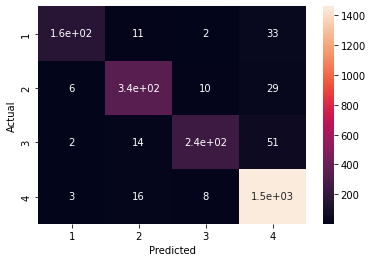

In [21]:
confusion_matrix = pd.crosstab(y_test, clf.predict(x_test), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()